In [1]:
import torch
import torch.nn as nn
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from pl_bolts.models.autoencoders.components import (
    resnet18_decoder,
    resnet18_encoder,
)

from torchsummary import summary
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Resize(256)])

train_ok_path = '~/Bureau/zentout/dataset/archive/casting_data/casting_data/train_one_class'
trainset = torchvision.datasets.ImageFolder(train_ok_path, transform = transform)
trainloader = DataLoader(trainset, batch_size=8, shuffle = True, num_workers=5)

train_def_path = '~/Bureau/zentout/dataset/archive/casting_data/casting_data/train_anomalous'
trainset_def = torchvision.datasets.ImageFolder(train_def_path, transform = transform)
trainloader_def = DataLoader(trainset_def, batch_size=1, shuffle = False)

test_path = '~/Bureau/zentout/dataset/archive/casting_data/casting_data/test'
testset = torchvision.datasets.ImageFolder(test_path, transform = transform)
testloader = DataLoader(testset, batch_size=1, shuffle = False)

classes = ['def','ok']

In [3]:
class VAE(nn.Module):
    def __init__(self,enc_out_dim=512, latent_dim=32, input_height=256):
        super(VAE, self).__init__()
        
        
        #encoder and decoder
        self.encoder = resnet18_encoder(False, False)
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim,
            input_height=input_height,
            first_conv=False,
            maxpool1=False
        )
        
        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)
        
        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))
        
    def gaussian_likelihood(self, x_hat, logscale, x):
        scale = torch.exp(logscale)
        mean = x_hat
        dist = torch.distributions.Normal(mean, scale)

        # measure prob of seeing image under p(x|z)
        log_pxz = dist.log_prob(x)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl
    
    def loss_elbo(self, x, x_hat, z, mu, std):
        kl = self.kl_divergence(z, mu, std)
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)
        elbo = (kl - recon_loss)
        return elbo.mean()
    
    def reparametrize(self,mu,log_var):
        #Reparametrization Trick to allow gradients to backpropagate from the 
        #stochastic part of the model
        sigma = torch.exp(0.5*log_var)
        z = torch.distributions.Normal(torch.zeros_like(mu),1).rsample()
        
        return mu + sigma*z
        
    def forward(self, x):
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        log_var = self.fc_var(encoded)
        std = torch.exp(log_var / 2)
        
        z_N = torch.distributions.Normal(torch.zeros_like(mu),1).rsample()
        z = self.reparametrize(mu,log_var)
        
        x_hat = self.decoder(z)
        
        elbo = self.loss_elbo(x, x_hat, z, mu, std)
        
        return x_hat, elbo

        

In [9]:
vae = VAE().to('cuda')
opt = torch.optim.Adam(vae.parameters(), lr=0.001)
loss_function = nn.MSELoss()
#summary(vae, (3,256,256))


In [10]:
def train(model,opt, trainloader, testloader, epochs):
    losses = []
    i = 0
    for epoch in range(epochs):
        print("starting training")
        step_loss = 0
        
        for images, labels in trainloader:
            out, loss = model(images.to('cuda'))
            
            opt.zero_grad()
            step_loss += loss.item()
            loss.backward()
            opt.step()
            
            losses.append(loss.item())
            
            if i%200 == 199:
                print(f'[Epoch : {epoch + 1}, step : {i}] loss : {step_loss/200}')
                step_loss = 0
            i+=1
        
        print(f'finished epoch {epoch +1}')
            
        if epoch%25 == 0:
            print('starting validation')
            val_losses = []
            def_losses = []
            ok_losses = []
            val_labels = []
            predictions = []
            model.eval()
            for val_image, label in testloader:
                val_out, elbo = model(val_image.to('cuda'))
                loss = loss_function(val_out,val_image.to('cuda'))
                val_losses.append(loss.item())
                val_labels.append(classes[label])
                
                if label.item() == 0:
                    def_losses.append(loss.item())
                else:
                    ok_losses.append(loss.item())
                
            threshold = max(ok_losses)
            for l in val_losses:
                if l > threshold:
                    predictions.append(classes[0])
                else:
                    predictions.append(classes[1])
            
            # Save losses density image
            save_validation_losses_density(epoch, val_losses, val_labels)
            save_confusion_matrix(epoch, val_labels, predictions)
            
            print(f'def_valid_loss : {sum(def_losses)/len(def_losses)} ')
            print(f'ok_valid_loss : {sum(ok_losses)/len(ok_losses)} ')
        
            
    return losses

starting training
[Epoch : 1, step : 199] loss : 166409.009296875
finished epoch 1
starting training
[Epoch : 2, step : 399] loss : 22184.138125
[Epoch : 2, step : 599] loss : 87987.338671875
finished epoch 2
starting validation
def_valid_loss : 0.026558387742910295 
ok_valid_loss : 0.02316477774279832 
starting training
[Epoch : 3, step : 799] loss : 317625175.64771485
[Epoch : 3, step : 999] loss : 58758.3187109375
finished epoch 3
starting training
[Epoch : 4, step : 1199] loss : 34526.8338671875
[Epoch : 4, step : 1399] loss : 57067.4115625
finished epoch 4
starting validation
def_valid_loss : 0.03019072369941681 
ok_valid_loss : 0.031548157551162345 
starting training
[Epoch : 5, step : 1599] loss : 45396.87400390625
[Epoch : 5, step : 1799] loss : 56434.205546875
finished epoch 5
starting training
[Epoch : 6, step : 1999] loss : 56426.7039453125
finished epoch 6
starting validation
def_valid_loss : 0.031267316738517736 
ok_valid_loss : 0.02938613617607883 
starting training
[Epoc

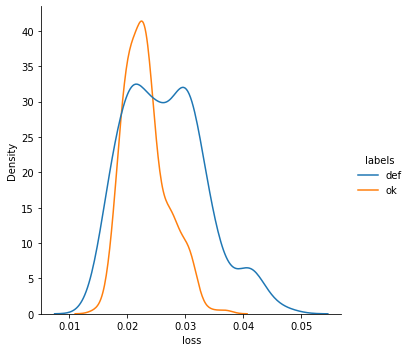

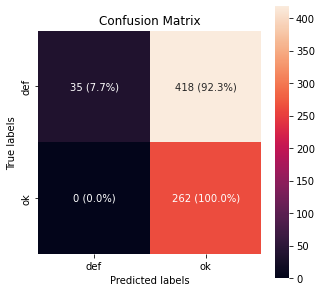

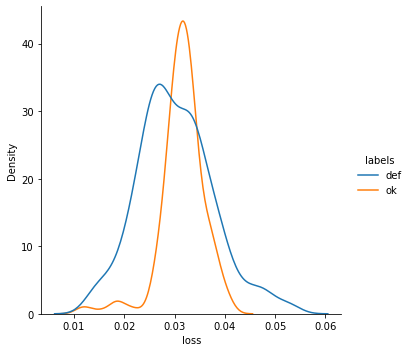

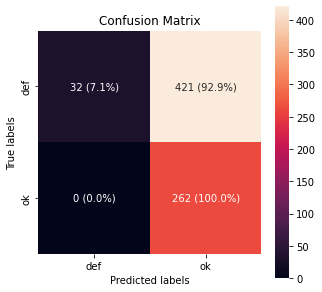

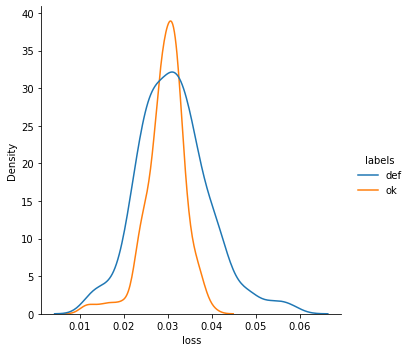

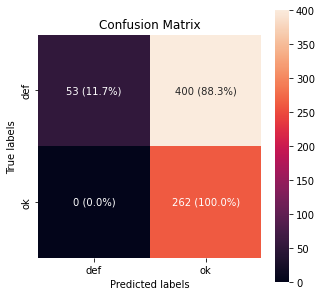

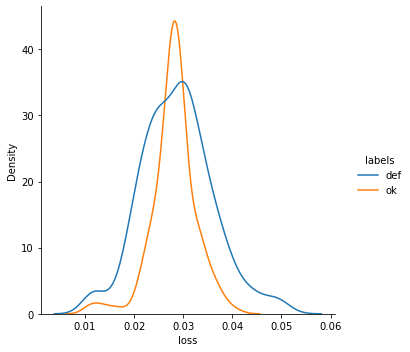

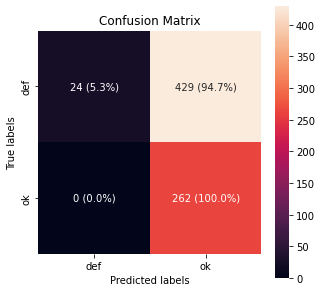

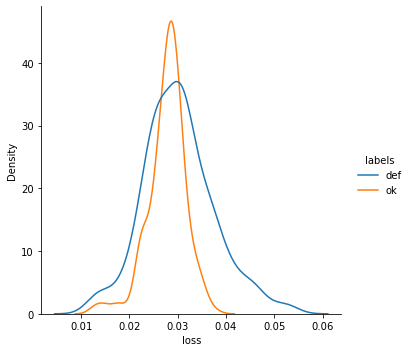

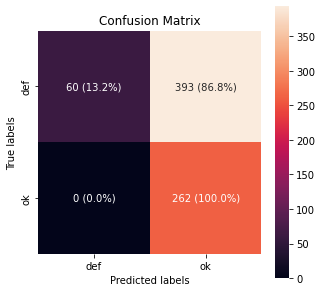

In [11]:
losses = train(vae, opt, trainloader,testloader, 500)

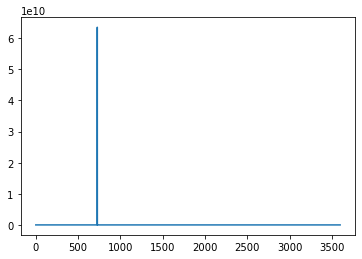

In [12]:
plt.plot(losses[0:-1])

          0         1         2         3         4         5         6  \
0  0.021761 -0.687594 -0.473324 -0.735568 -0.703913  0.043840 -0.691503   
1 -0.577009 -1.568153 -1.266223 -1.636407 -1.591588 -0.550550 -1.573304   
2 -1.147569 -1.049171 -1.081294 -1.045055 -1.047972 -1.137048 -1.049859   
3 -1.466340 -0.874722 -1.049738 -0.837365 -0.861978 -1.473102 -0.872704   
4  0.314957  0.060659  0.140702  0.044475  0.055025  0.316347  0.060167   

          7  
0 -0.486077  
1 -1.284569  
2 -1.080751  
3 -1.042441  
4  0.136904  


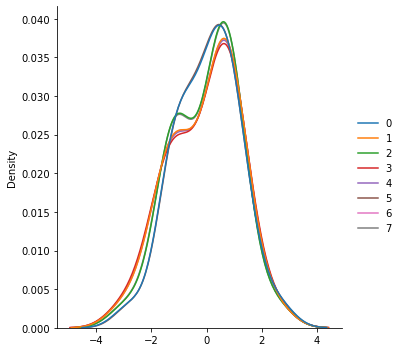

In [13]:
import numpy as np
import scipy.stats as stats
ex = iter(trainloader)
images, labels = next(ex)

out, loss = vae(images[0].unsqueeze(0).to('cuda'))
encoded = vae.encoder(images.to('cuda'))
MU = vae.fc_mu(encoded)
log_var = vae.fc_var(encoded)
std = torch.exp(log_var / 2)
df = pd.DataFrame(MU.permute(1,0).to('cpu').detach().numpy())
sns.displot(df, kind="kde")
print(df.head())

torch.Size([3, 256, 256])


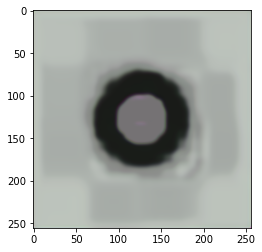

In [14]:
import matplotlib.pyplot as plt
print(out.squeeze().size())
out = out.to('cpu')
plt.imshow(out.squeeze().permute(1,2,0).detach().numpy())

In [8]:
def save_validation_losses_density(epoch, val_losses, val_labels):
    if not os.path.exists('density_images'):
            os.makedirs('density_images')
    df = pd.DataFrame(val_losses, columns=['loss'])
    df['labels'] = val_labels
    #df_def = pd.DataFrame(losses_def, columns=['loss_def'])
    sns.displot(df,x="loss" ,hue="labels", kind="kde")
    plt.savefig(f"density_images/Density-epoch-{epoch+1}.png")

In [14]:
t = torch.tensor([1,2,3])
print(torch.max(t))

tensor(3)


In [7]:
def save_confusion_matrix(epoch, labels, predictions):
    if not os.path.exists('confusion_matrix_images'):
            os.makedirs('confusion_matrix_images')
    classes = ['def','ok']
    matrix = confusion_matrix(labels, predictions, labels=classes)
    annot = [["00","01"],["10","11"]]
    for i in range(2):
        for j in range(2):
            percentage = matrix[i][j] / sum(matrix[i]) * 100
            annot[i][j] = f"{matrix[i][j]} ({percentage:.1f}%)"

    # Plot the confusion matrix with Seaborn
    fig = plt.figure(figsize=(5,5))
    ax = plt.subplot()

    # annot=True to annotate cells, ftm='g' to disable scientific notation
    sns.heatmap(matrix, annot=annot, square=True, fmt="s", ax=ax)
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels([classes[0], classes[1]])
    ax.yaxis.set_ticklabels([classes[0], classes[1]])
    plt.savefig(f"confusion_matrix_images/epoch-{epoch+1}.png")